In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss,roc_auc_score,accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import f1_score, recall_score, classification_report
from sklearn.metrics import fbeta_score
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from itertools import cycle
import pickle


In [2]:
train1 = pd.read_csv('features.csv')
train1.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject,FinalGrade,Regularity,Grade1,Grade2
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11,Portuguese,Satisfactory,Always Regular,Failure,Satisfactory
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11,Portuguese,Satisfactory,Always Regular,Poor,Satisfactory
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12,Portuguese,Satisfactory,Always Regular,Satisfactory,Satisfactory
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14,Portuguese,Satisfactory,Always Regular,Satisfactory,Satisfactory
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13,Portuguese,Satisfactory,Always Regular,Satisfactory,Satisfactory


In [3]:

def correlation(df):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(20, 15))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.savefig('Correlation.png', bbox_inches='tight')
    plt.show()


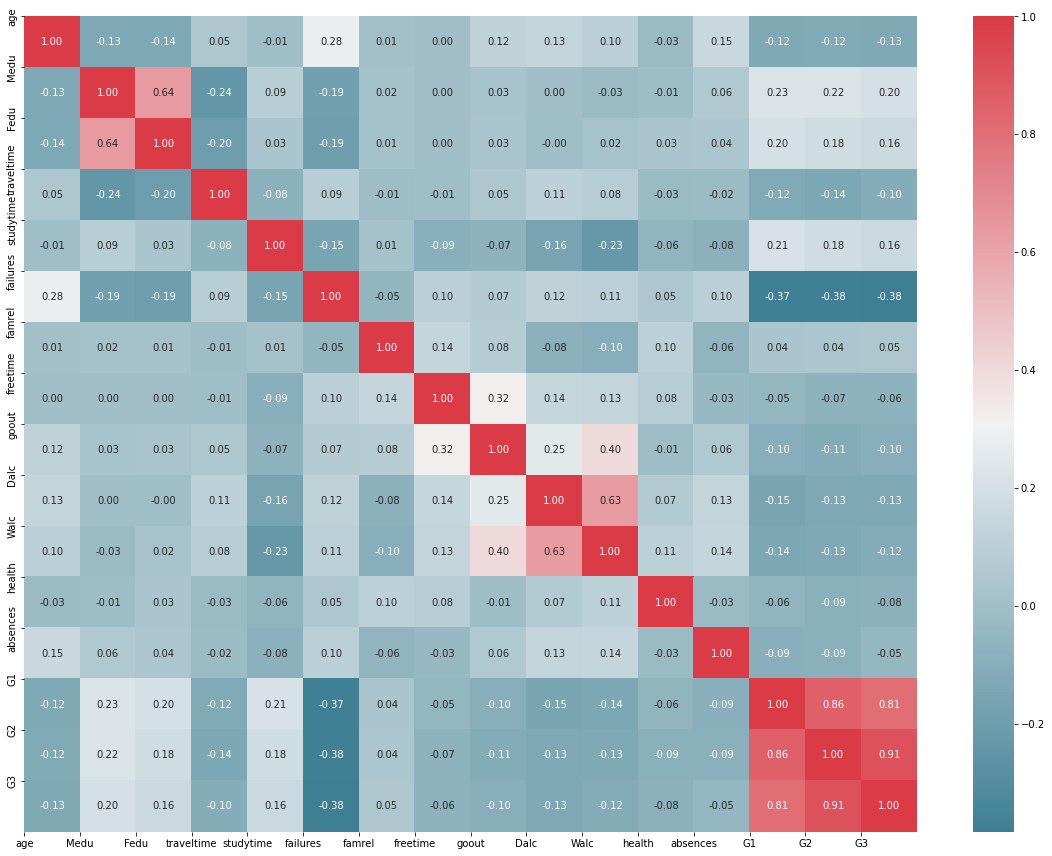

In [4]:
correlation(train1)

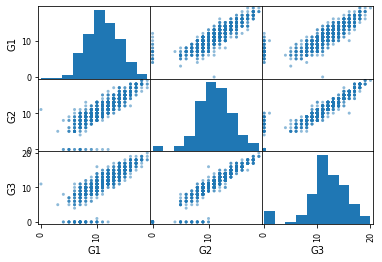

In [5]:
from pandas.plotting import scatter_matrix
grades = train1[['G1','G2','G3']]
scatter_matrix(grades)
plt.savefig('grades.png', bbox_inches='tight')
plt.show()


In [6]:
le=preprocessing.LabelEncoder()


In [7]:
le.fit(train1['FinalGrade'])
train1['FinalGrade']=le.transform(train1['FinalGrade'])
y=train1['FinalGrade']
# train1 = train1.drop(labels=['Regularity','Grade1','Grade2'],axis=1)


In [8]:
train1 = pd.get_dummies(train1)


In [9]:
train1.head(10)


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,FinalGrade,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,subject_Maths,subject_Portuguese,Regularity_Always Regular,Regularity_Irregular,Regularity_Mostly Regular,Regularity_Regular,Grade1_Excellent,Grade1_Failure,Grade1_Good,Grade1_Poor,Grade1_Satisfactory,Grade2_Excellent,Grade2_Failure,Grade2_Good,Grade2_Poor,Grade2_Satisfactory
0,18,4,4,2,2,0,4,3,4,1,1,3,4,0,11,11,4,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1,17,1,1,1,2,0,5,3,3,1,1,3,2,9,11,11,4,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1
2,15,1,1,1,2,0,4,3,2,2,3,3,6,12,13,12,4,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,15,4,2,1,3,0,3,2,2,1,1,5,0,14,14,14,4,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1
4,16,3,3,1,2,0,4,3,2,1,2,5,0,11,13,13,4,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1
5,16,4,3,1,2,0,5,4,2,1,2,5,6,12,12,13,4,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1
6,16,2,2,1,2,0,4,4,4,1,1,3,0,13,12,13,4,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1
7,17,4,4,2,2,0,4,1,4,1,1,1,2,10,13,13,4,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1
8,15,3,2,1,2,0,4,2,2,1,1,1,0,15,16,17,2,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0
9,15,3,4,1,2,0,5,5,1,1,1,5,0,12,12,13,4,1,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1


In [10]:
# y=train1.FinalGrade
train1 = train1.drop(labels=['G3','FinalGrade','Fjob_at_home','Fjob_teacher','Pstatus_A','Pstatus_T'],axis=1)
train1.head()


# # SPLIT DATA 


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,subject_Maths,subject_Portuguese,Regularity_Always Regular,Regularity_Irregular,Regularity_Mostly Regular,Regularity_Regular,Grade1_Excellent,Grade1_Failure,Grade1_Good,Grade1_Poor,Grade1_Satisfactory,Grade2_Excellent,Grade2_Failure,Grade2_Good,Grade2_Poor,Grade2_Satisfactory
0,18,4,4,2,2,0,4,3,4,1,1,3,4,0,11,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1,17,1,1,1,2,0,5,3,3,1,1,3,2,9,11,1,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1
2,15,1,1,1,2,0,4,3,2,2,3,3,6,12,13,1,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,15,4,2,1,3,0,3,2,2,1,1,5,0,14,14,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1
4,16,3,3,1,2,0,4,3,2,1,2,5,0,11,13,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1


In [11]:
x_train,x_val,y_train,y_val = train_test_split(train1,y,random_state=0)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)


# # Confusion Matrix


(783, 70)
(783,)
(261, 70)
(261,)


In [12]:


def confusionmatrix(y_val,y_pred):
    labels = list(range(0,5))
    cm=confusion_matrix(y_val,y_pred)
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);
    plt.savefig('confusion_matrix.png', bbox_inches='tight')
    
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    total = lambda x : x.sum()/5
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print('percentage of sensitivity = '+str(total(TPR)*100))

    # Specificity or true negative rate
    TNR = TN/(TN+FP) 

    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print('percentage of precision = '+str(total(PPV)*100))
    # Negative predictive value
    NPV = TN/(TN+FN)

    # Fall out or false positive rate
    FPR = FP/(FP+TN)

    # False negative rate
    FNR = FN/(TP+FN)

    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print('Accuracy percentage = '+str(total(ACC)*100))


# # ROC plot


In [13]:
def ROC_plot(x_train,x_val,model):
    train = pd.read_csv('features.csv')
    train.head()
    y=train[['FinalGrade']]
    train = train.drop(['G3'],axis=1);
    train = train.drop(['FinalGrade'],axis=1);
    train = train.drop(['G2'],axis=1);
    train = train.drop(['G1'],axis=1);
    y = label_binarize(y, classes=['Failure','Poor','Satisfactory','Good','Excellent'])
    n_classes = y.shape[1]
    
    X_train, X_test, y_train, y_test = train_test_split(train,y,random_state=0)
    
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(x_train, y_train).decision_function(x_val)
    y_score.shape
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    # Individual ROC
    plt.figure()
    lw = 2
    for i in (0,1):
        plt.subplot(1,2,i+1)
        plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic label'+str(i))
        plt.legend(loc="lower right")
    plt.savefig('ROC1.png', bbox_inches='tight')
    plt.plot()

    plt.figure()
    lw = 2
    for i in (2,3):
        plt.subplot(1,2,i-1)
        plt.plot(fpr[i], tpr[i], color='red',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic label'+str(i))
        plt.legend(loc="lower right")
    plt.savefig('ROC2.png', bbox_inches='tight')
    plt.plot()

    plt.figure()
    lw = 2
    plt.subplot(1,2,1)
    plt.plot(fpr[4], tpr[4], color='grey',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[4])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic label'+str(4))
    plt.legend(loc="lower right")
    plt.savefig('ROC3',box_inches='tight')
    plt.plot()
    
    
    # Combined ROC
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
        print('Area Under the Curve with label '+str(i)+' is '+str(roc_auc[i]))
    plt.savefig('ROC4', bbox_inches='tight')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.rcParams["figure.figsize"] = (10,6)


# # Fscore


In [14]:
def Fscore(y_val,y_pred):
    print('f score = ' + str(f1_score(y_val, y_pred, average="macro")))


In [15]:

def recall(y_val,y_pred):
    print('percentage of recall score = '+str(recall_score(y_val, y_pred, average="macro"))) 


# # Classification Report


In [16]:
def report(y_val,y_pred):
    target_names = ['Failure','Poor','Satisfactory','Good','Excellent']
    print('Classification Report')
    print(classification_report(y_val, y_pred, target_names=target_names))


# # F Beta score


In [17]:
def fbeta(y_val,y_pred):
    print('Fbeta score = ' + str(fbeta_score(y_val,y_pred,average='macro', beta=0.5)))


# # LOGISTIC REGRESSION 


In [18]:


def logistic_regression_model(x_train,y_train,x_val,y_val):
    lr =  LogisticRegression()
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_val)
    y_predict = lr.predict_proba(x_val)
    print("Log_Loss: ",log_loss(y_val,y_predict))
    print("Accuracy_Score: ",accuracy_score(y_val,y_pred))
    confusionmatrix(y_val,y_pred)
    Fscore(y_val,y_pred)
    recall(y_val,y_pred)
    report(y_val,y_pred)
    fbeta(y_val,y_pred)
    return lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Log_Loss:  0.5056336917138913
Accuracy_Score:  0.7931034482758621
percentage of sensitivity = 71.68054438786146
percentage of precision = 72.83862148038718
Accuracy percentage = 91.72413793103449
f score = 0.7196732195232944
percentage of recall score = 0.7168054438786146
Classification Report
              precision    recall  f1-score   support

     Failure       0.57      0.67      0.62         6
        Poor       0.57      0.53      0.55        15
Satisfactory       0.91      0.73      0.81        41
        Good       0.77      0.79      0.78        91
   Excellent       0.82      0.86      0.84       108

    accuracy                           0.79       261
   macro avg       0.73      0.72      0.72       261
weighted avg       0.80      0.79      0.79       261

Fbeta score = 0.7241346962023599


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Area Under the Curve with label 0 is 0.9533875338753388
Area Under the Curve with label 1 is 0.9219133807369102
Area Under the Curve with label 2 is 0.8936092955700798
Area Under the Curve with label 3 is 0.9763858093126385
Area Under the Curve with label 4 is 0.9947712418300654


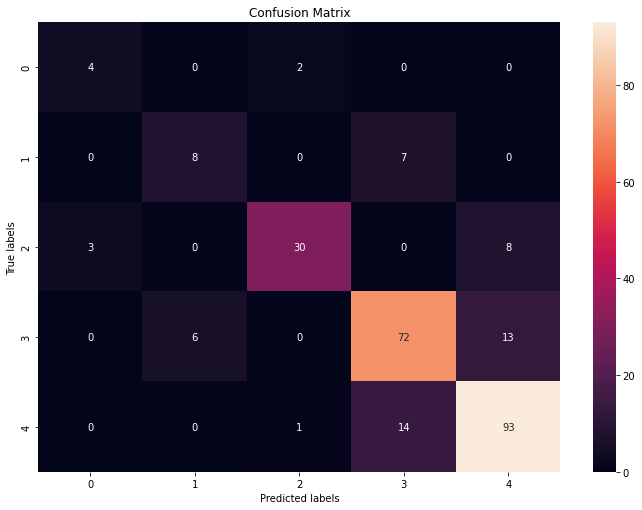

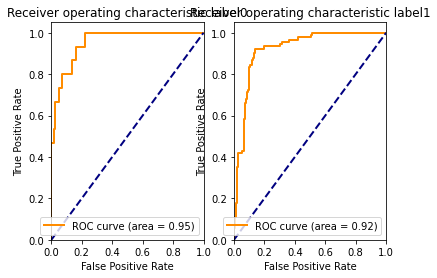

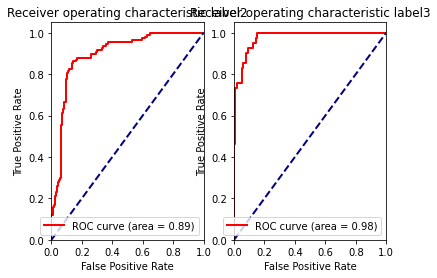

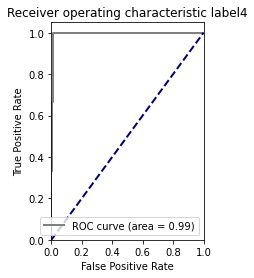

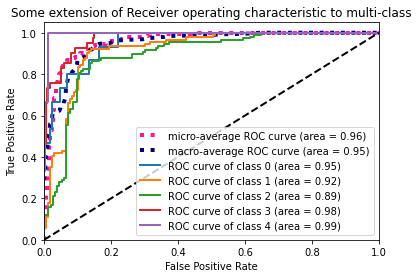

In [19]:


model =logistic_regression_model(x_train,y_train,x_val,y_val)
ROC_plot(x_train,x_val,model)


In [21]:
filename = 'pickle/model_lr.pkl'
outfile = open(filename,'wb')
pickle.dump(model,outfile)
outfile.close()


In [22]:
def random_forest_model(x_train,y_train,x_val,y_val):
    random_forest = RandomForestClassifier(n_estimators=28,max_depth=5,random_state=0)

    forest = random_forest.fit(x_train, y_train)
    print("Random Forest Train data Score" , ":" , forest.score(x_train, y_train) 
          , "," ,"Validation data Score" ,":" , forest.score(x_val, y_val))
    Y_pred = random_forest.predict_proba(x_val)
    Y_pred1 = random_forest.predict(x_val)
    print("Log_Loss: ",log_loss(y_val,Y_pred))
    confusionmatrix(y_val,Y_pred1)
    Fscore(y_val,Y_pred1)
    recall(y_val,Y_pred1)
    report(y_val,Y_pred1)
    fbeta(y_val,Y_pred1)
    return forest


Random Forest Train data Score : 0.8620689655172413 , Validation data Score : 0.8160919540229885
Log_Loss:  0.5500067951388179
percentage of sensitivity = 70.73752444484151
percentage of precision = 79.21069755335762
Accuracy percentage = 92.64367816091955
f score = 0.7359310376186469
percentage of recall score = 0.7073752444484152
Classification Report
              precision    recall  f1-score   support

     Failure       0.67      0.67      0.67         6
        Poor       0.75      0.40      0.52        15
Satisfactory       0.94      0.73      0.82        41
        Good       0.77      0.87      0.82        91
   Excellent       0.83      0.87      0.85       108

    accuracy                           0.82       261
   macro avg       0.79      0.71      0.74       261
weighted avg       0.82      0.82      0.81       261

Fbeta score = 0.7646814768245026


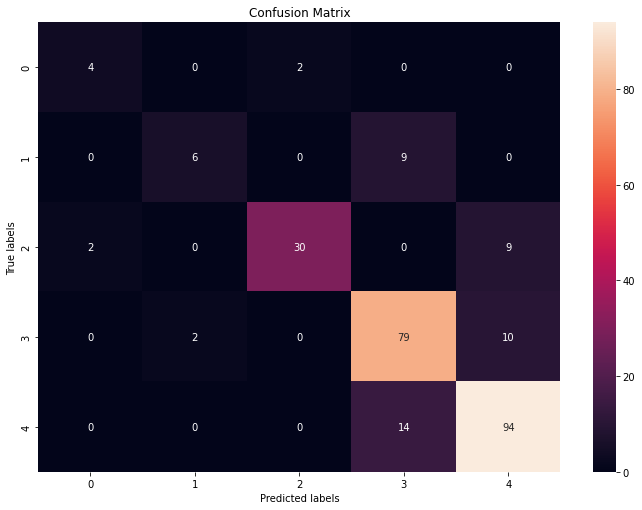

In [23]:

model = random_forest_model(x_train,y_train,x_val,y_val)


In [24]:
filename = 'pickle/model_rf.pkl'
outfile = open(filename,'wb')
pickle.dump(model,outfile)
outfile.close()


In [25]:

def SVM_Model(X_train,Y_train,X_test,y_val):
    svc = SVC()
    svc.fit(X_train, Y_train)
    Y_pred = svc.predict(X_test)
    print("SVM Train data Score" , ":" , svc.score(X_train, y_train)
          , "," ,"Validation data Score" ,":" , svc.score(X_test, y_val))
    confusionmatrix(y_val,Y_pred)
    Fscore(y_val,Y_pred)
    recall(y_val,Y_pred)
    report(y_val,Y_pred)
    fbeta(y_val,Y_pred)
    return svc



SVM Train data Score : 0.8122605363984674 , Validation data Score : 0.8045977011494253
percentage of sensitivity = 56.778442876003844
percentage of precision = nan
Accuracy percentage = 92.18390804597702
f score = 0.5905203443955551
percentage of recall score = 0.5677844287600384
Classification Report
              precision    recall  f1-score   support

     Failure       0.00      0.00      0.00         6
        Poor       1.00      0.33      0.50        15
Satisfactory       0.82      0.76      0.78        41
        Good       0.78      0.88      0.82        91
   Excellent       0.82      0.87      0.84       108

    accuracy                           0.80       261
   macro avg       0.68      0.57      0.59       261
weighted avg       0.79      0.80      0.79       261

Fbeta score = 0.6280175879077761


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-

Area Under the Curve with label 0 is 0.9766937669376694
Area Under the Curve with label 1 is 0.9281835811247576
Area Under the Curve with label 2 is 0.9253207455821835
Area Under the Curve with label 3 is 0.9667405764966741
Area Under the Curve with label 4 is 0.9980392156862745


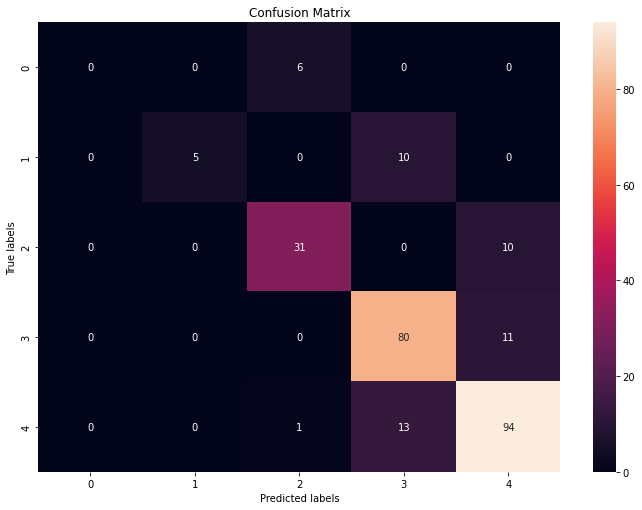

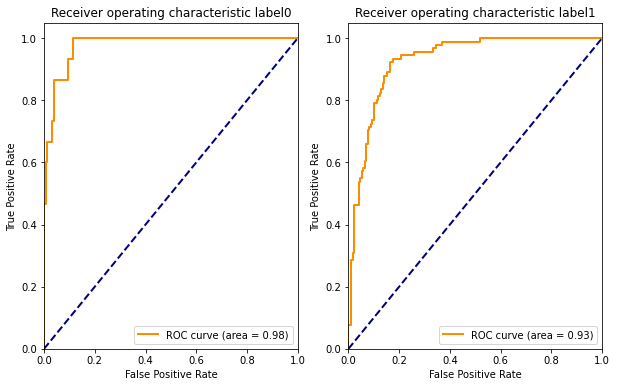

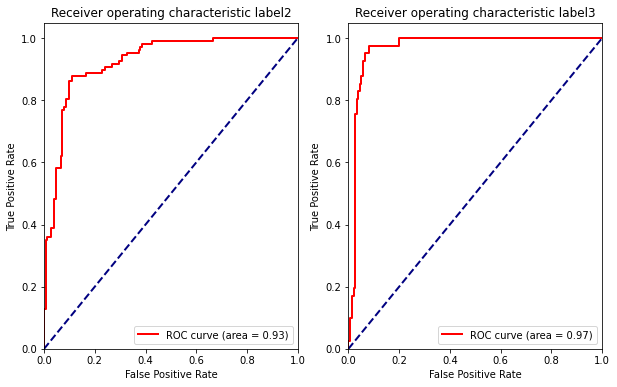

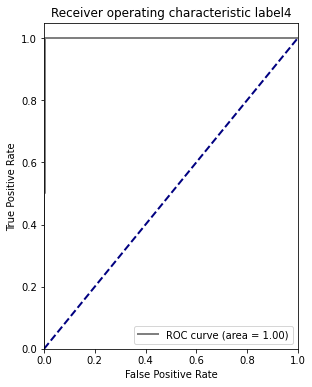

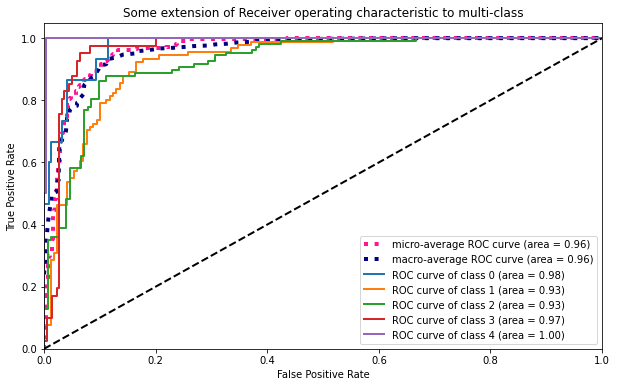

In [26]:

model = SVM_Model(x_train,y_train,x_val,y_val)
ROC_plot(x_train,x_val,model)


In [27]:

filename = 'pickle/model_svm.pkl'
outfile = open(filename,'wb')
pickle.dump(model,outfile)
outfile.close()


In [28]:

def Decison_tree_Model(x_train,y_train,x_val,y_val):
    tree = DecisionTreeClassifier(min_samples_leaf=9,random_state=0)
    tf= tree.fit(x_train, y_train)
    y_pred = tf.predict(x_val)
    y_predict = tf.predict_proba(x_val)
    print("Decisioin Tree Train data Score" , ":" , tf.score(x_train, y_train) 
          , "," , "Validation data Score" ,":" , tf.score(x_val, y_val))
    confusionmatrix(y_val,y_pred)
    print("Log_Loss: ",log_loss(y_val,y_predict))
    Fscore(y_val,y_pred)
    recall(y_val,y_pred)
    report(y_val,y_pred)
    fbeta(y_val,y_pred)
    return tree



Decisioin Tree Train data Score : 0.8671775223499362 , Validation data Score : 0.8352490421455939
percentage of sensitivity = 84.70339597168865
percentage of precision = 78.16673491673491
Accuracy percentage = 93.40996168582377
Log_Loss:  1.7419152630748576
f score = 0.8033768498313509
percentage of recall score = 0.8470339597168864
Classification Report
              precision    recall  f1-score   support

     Failure       0.60      1.00      0.75         6
        Poor       0.69      0.73      0.71        15
Satisfactory       0.94      0.83      0.88        41
        Good       0.83      0.80      0.82        91
   Excellent       0.85      0.87      0.86       108

    accuracy                           0.84       261
   macro avg       0.78      0.85      0.80       261
weighted avg       0.84      0.84      0.84       261

Fbeta score = 0.7885344808414613


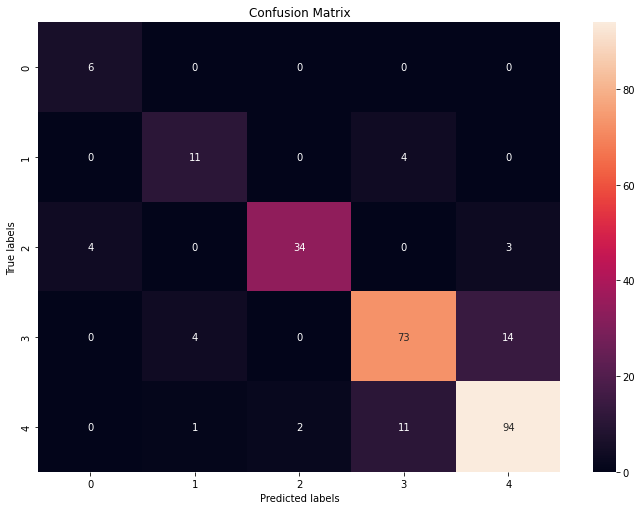

In [29]:
model = Decison_tree_Model(x_train,y_train,x_val,y_val)


In [30]:

filename = 'pickle/model_dt.pkl'
outfile = open(filename,'wb')
pickle.dump(model,outfile)
outfile.close()



In [31]:

def ada_boost_model(x_train,y_train,x_val,y_val):
    ada = AdaBoostClassifier(n_estimators=2)
    af = ada.fit(x_train, y_train)
    y_pred = af.predict(x_val)
    y_predict = af.predict_proba(x_val)
    print("Ada Boost Train data Score" , ":" , af.score(x_train, y_train) 
          , "," ,"Validation data Score" ,":" , af.score(x_val, y_val))
    print("Log_Loss: ",log_loss(y_val,y_predict))
    confusionmatrix(y_val,y_pred)
    Fscore(y_val,y_pred)
    recall(y_val,y_pred)
    report(y_val,y_pred)
    fbeta(y_val,y_pred)
    return ada


Ada Boost Train data Score : 0.7675606641123882 , Validation data Score : 0.7931034482758621
Log_Loss:  0.6780033285371911
percentage of sensitivity = 53.378698988455085
percentage of precision = nan
Accuracy percentage = 91.72413793103449
f score = 0.4966256670571392
percentage of recall score = 0.5337869898845509
Classification Report
              precision    recall  f1-score   support

     Failure       0.00      0.00      0.00         6
        Poor       0.00      0.00      0.00        15
Satisfactory       0.73      0.98      0.83        41
        Good       0.73      0.93      0.82        91
   Excellent       0.92      0.76      0.83       108

    accuracy                           0.79       261
   macro avg       0.48      0.53      0.50       261
weighted avg       0.75      0.79      0.76       261

Fbeta score = 0.4820380879923783


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-

Area Under the Curve with label 0 is 0.8715447154471545
Area Under the Curve with label 1 is 0.9103749191984486
Area Under the Curve with label 2 is 0.9097676107480028
Area Under the Curve with label 3 is 0.9756097560975611
Area Under the Curve with label 4 is 0.988235294117647


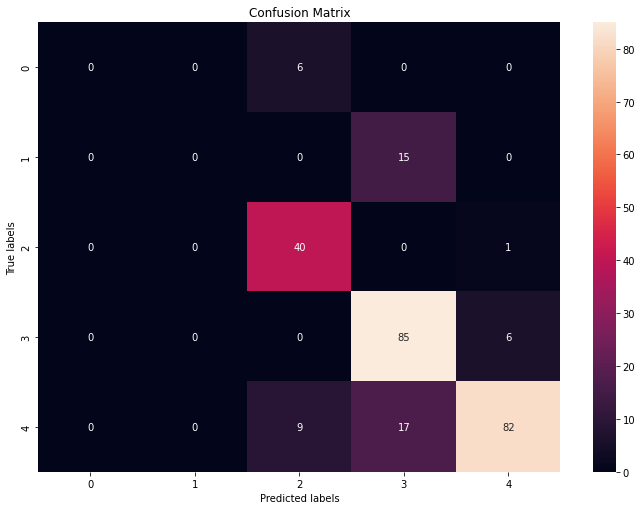

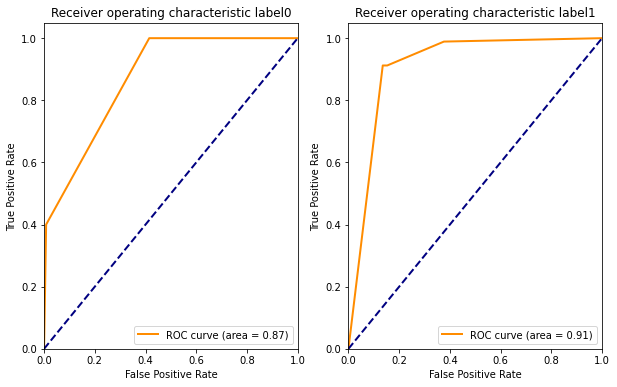

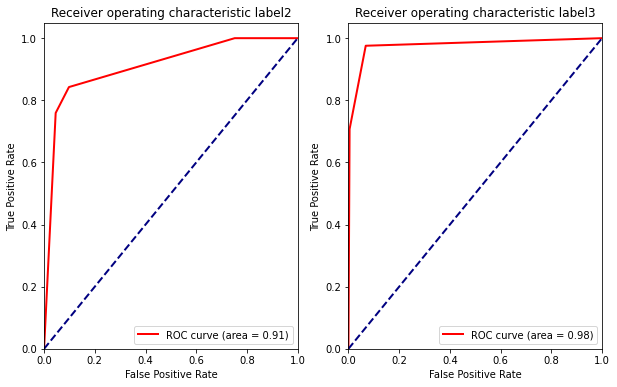

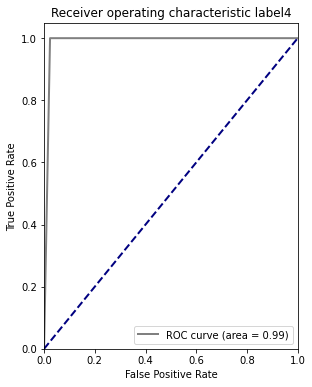

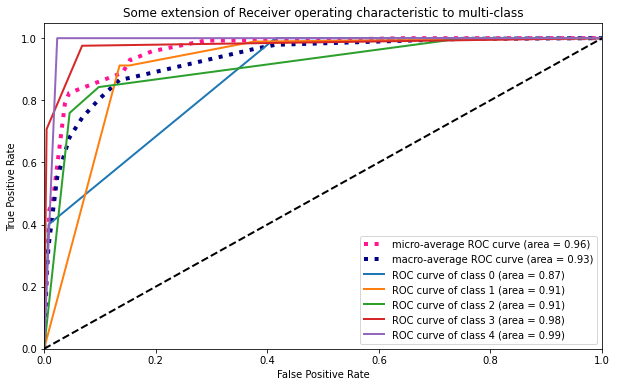

In [32]:

model = ada_boost_model(x_train,y_train,x_val,y_val)
ROC_plot(x_train,x_val,model)


In [33]:

filename = 'pickle/model_ada.pkl'
outfile = open(filename,'wb')
pickle.dump(model,outfile)
outfile.close()


In [34]:

def XGBoost(x_train,y_train,x_val,y_val):
    model = XGBClassifier()
    model = XGBClassifier(learning_rate=0.1,n_estimators=80)
    mf = model.fit(x_train,y_train)
    y_pred=model.predict(x_val)
    y_predict = mf.predict_proba(x_val)
    print("XGBoost Train data Score" , ":" , mf.score(x_train, y_train) 
          , "," ,"Validation data Score" ,":" , mf.score(x_val, y_val))
    print("Log_Loss: ",log_loss(y_val,y_predict))
    confusionmatrix(y_val,y_pred)
    Fscore(y_val,y_pred)
    recall(y_val,y_pred)
    report(y_val,y_pred)
    fbeta(y_val,y_pred)
    
    
    # plot feature importance
    fig, ax = plt.subplots(figsize=(10, 20))
    plot_importance(model, ax=ax)
    plt.savefig('Feature_Engineering.png', bbox_inches='tight')
    plt.show()
    return model


XGBoost Train data Score : 0.9386973180076629 , Validation data Score : 0.8850574712643678
Log_Loss:  0.3860022827547572
percentage of sensitivity = 89.47816591719031
percentage of precision = 89.39073297836184
Accuracy percentage = 95.40229885057471
f score = 0.8920378627465831
percentage of recall score = 0.8947816591719031
Classification Report
              precision    recall  f1-score   support

     Failure       0.86      1.00      0.92         6
        Poor       0.92      0.80      0.86        15
Satisfactory       0.95      0.90      0.92        41
        Good       0.85      0.90      0.87        91
   Excellent       0.90      0.87      0.88       108

    accuracy                           0.89       261
   macro avg       0.89      0.89      0.89       261
weighted avg       0.89      0.89      0.89       261

Fbeta score = 0.8926126068839595


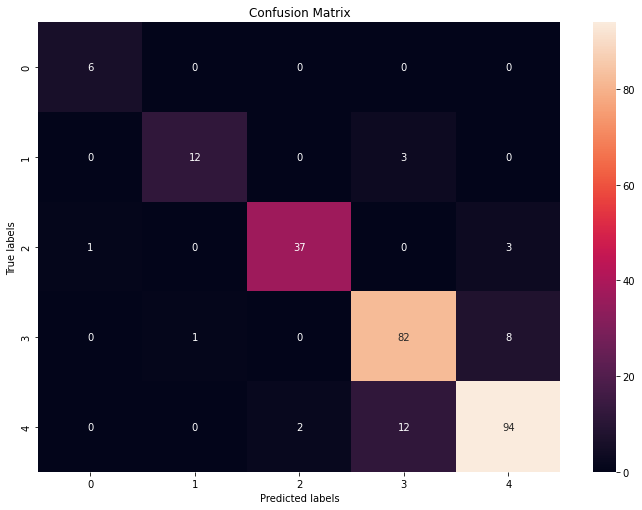

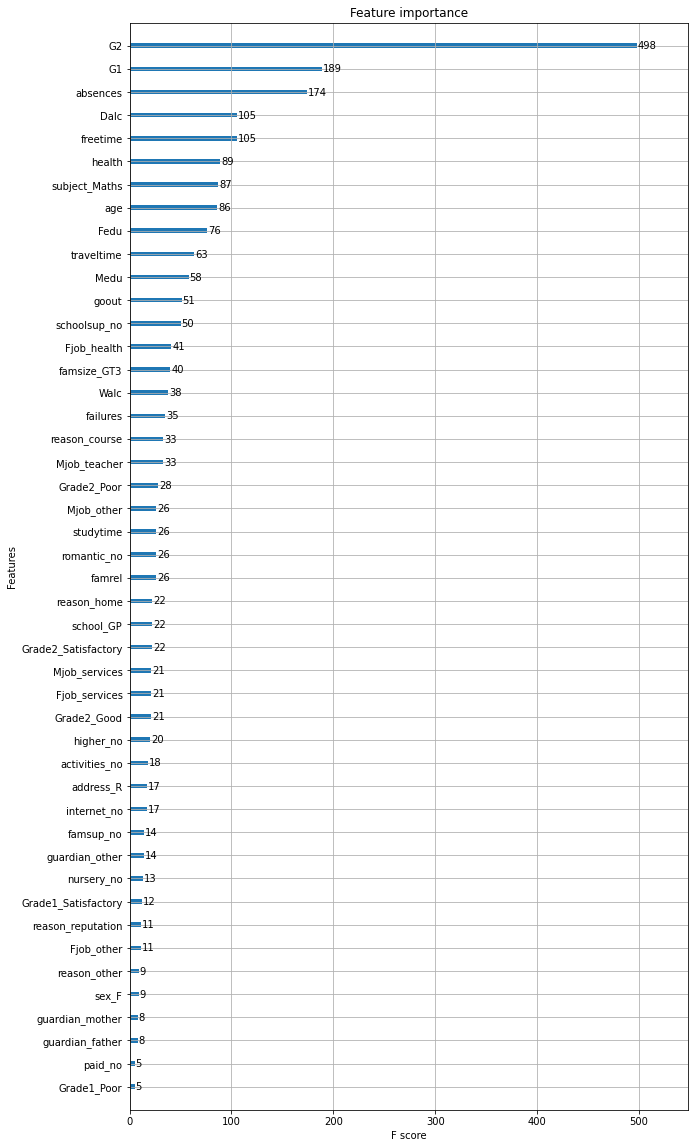

In [35]:
model = XGBoost(x_train,y_train,x_val,y_val)


In [36]:

def k_cross_validations(x_train,y_train,):
    X = x_train
    y = y_train
    kf = KFold(n_splits=10) # Define the split - into 2 folds 
    kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
    print(kf) 
    KFold(n_splits=10, random_state=None, shuffle=False)
    return kf


In [37]:
kf = k_cross_validations(x_train,y_train)
classifier = model
cross_val_score(classifier,x_train, y_train, cv=kf, n_jobs=1)


KFold(n_splits=10, random_state=None, shuffle=False)


array([0.83544304, 0.86075949, 0.81012658, 0.82051282, 0.83333333,
       0.79487179, 0.84615385, 0.80769231, 0.79487179, 0.85897436])

In [38]:

def FeatureImportance():
    # Build a classification task using 3 informative features
    X, y = make_classification(n_samples=1000,
                               n_features=10,
                               n_informative=3,
                               n_redundant=0,
                               n_repeated=0,
                               n_classes=2,
                               random_state=0,
                               shuffle=False)

    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()


Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


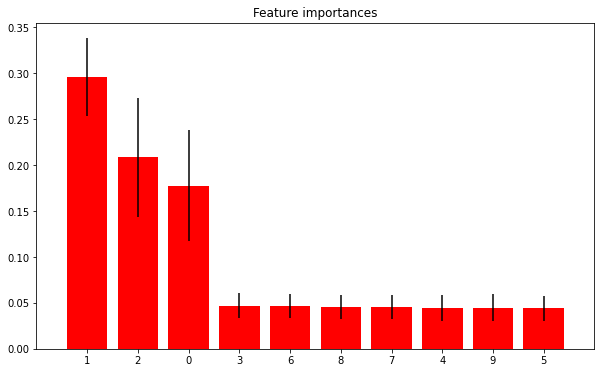

In [39]:
FeatureImportance()


# # Finally we choose XGBoost Model
# 
# # Train data Score : 0.9386973180076629 
# 
# # Validation data Score : 0.8850574712643678


In [40]:
filename = 'pickle/model_xgb.pkl'
outfile = open(filename,'wb')
pickle.dump(model,outfile)
outfile.close()
